In [1]:
!pip install torch_geometric


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [20]:
import networkx as nx
import torch
import os
import pandas as pd
from torch_geometric.data import Data
import numpy as np
from dateutil.parser import parse

In [30]:
# process data
# each node is a team (for a year), edges
game_info = pd.read_csv("nfl-game-info.csv")
# team_info = pd.read_csv("team_stats_2003_2023.csv")

teams = pd.concat([game_info['Home Team'], game_info['Away Team']]).unique()
teams = list(teams)
teams.remove('San Diego Chargers')
teams.remove('Washington Redskins')
teams.remove('St. Louis Rams')
teams.remove('Oakland Raiders')
teams.remove('Washington Football Team')
teams = np.array(teams)
print(teams)
team_to_idx = {team: i for i, team in enumerate(teams)}

edge_index = []
edge_attr = []

for _, row in game_info.iterrows():
  date = parse(row["Date"])
  if date < parse('2024-9-5'):
    continue
  # create an edge between two teams,
  team1_idx = team_to_idx[row['Home Team']]
  team2_idx = team_to_idx[row['Away Team']]

  # Add an undirected edge (team1 -> team2 and team2 -> team1)
  edge_index.append([team1_idx, team2_idx])
  edge_index.append([team2_idx, team1_idx])

  edge_attr.append([row["Home Score"], row["Away Score"]])
  edge_attr.append([row["Away Score"], row["Home Score"]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(teams))
print(data)

['Pittsburgh Steelers' 'San Francisco 49ers' 'Denver Broncos'
 'Las Vegas Raiders' 'Washington Commanders' 'Los Angeles Chargers'
 'Seattle Seahawks' 'Cincinnati Bengals' 'Cleveland Browns'
 'Detroit Lions' 'Houston Texans' 'Jacksonville Jaguars' 'Miami Dolphins'
 'New England Patriots' 'Tampa Bay Buccaneers' 'Los Angeles Rams'
 'Arizona Cardinals' 'Atlanta Falcons' 'Buffalo Bills' 'Green Bay Packers'
 'Indianapolis Colts' 'Minnesota Vikings' 'New York Giants'
 'New Orleans Saints' 'New York Jets' 'Carolina Panthers' 'Dallas Cowboys'
 'Baltimore Ravens' 'Philadelphia Eagles' 'Tennessee Titans'
 'Chicago Bears' 'Kansas City Chiefs']
Data(edge_index=[2, 246], edge_attr=[246, 2], num_nodes=32)


In [31]:
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader

In [41]:
# Random node features with a fixed dimensionality, e.g., 16
num_nodes = len(teams)
node_feature_dim = 64
node_features = torch.randn((num_nodes, node_feature_dim), dtype=torch.float, )

# Define a GAT model
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.conv2(x, edge_index)
        return x
    
    def encode(self, x, edge_index):
        return self.forward(x, edge_index)

    def decode(self, z, edge_index):
        # Use dot product to predict if an edge exists
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=1)

# Initialize the model
model = GATModel(in_channels=node_feature_dim, hidden_channels=32, out_channels=16)

# Move model and data to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
node_features = node_features.to(device)

# Get GAT embeddings in a single forward pass
with torch.no_grad():
    embeddings = model(node_features, data.edge_index)

print("GAT Embeddings:")
print(embeddings)

GAT Embeddings:
tensor([[-6.1333e-02, -4.3268e-02, -1.9866e-01,  1.1529e-01,  2.2309e-01,
         -4.2516e-03, -2.0379e-01,  3.4126e-03,  2.7632e-02,  3.3150e-01,
          1.8644e-01, -1.6548e-01, -1.3355e-01, -2.0784e-01, -2.3123e-02,
         -7.9103e-02],
        [ 4.5031e-02, -2.0029e-03, -2.2056e-01,  7.0360e-02,  2.0215e-01,
         -1.4469e-01, -2.8555e-01, -9.7215e-02, -5.2676e-03,  3.2157e-02,
          2.3272e-01, -1.4107e-01, -2.4896e-01, -3.5532e-01, -1.4673e-01,
         -2.1515e-01],
        [-1.3285e-01,  1.7140e-02, -1.7172e-01,  2.5051e-02,  1.5845e-01,
          4.8146e-02, -5.7099e-02,  2.2987e-01,  2.5670e-02,  5.3776e-01,
          1.9924e-01, -1.4543e-01, -4.8191e-02, -2.2158e-01, -2.7244e-02,
          2.2978e-02],
        [-2.0443e-01, -5.7864e-02, -2.4767e-01,  6.9382e-02,  1.5493e-01,
         -2.0021e-01, -6.6910e-03,  1.4644e-01,  1.1276e-01,  2.4978e-01,
          2.8182e-01, -1.3184e-01, -1.5315e-01, -1.4859e-01,  1.5075e-01,
          5.1427e-03],
    

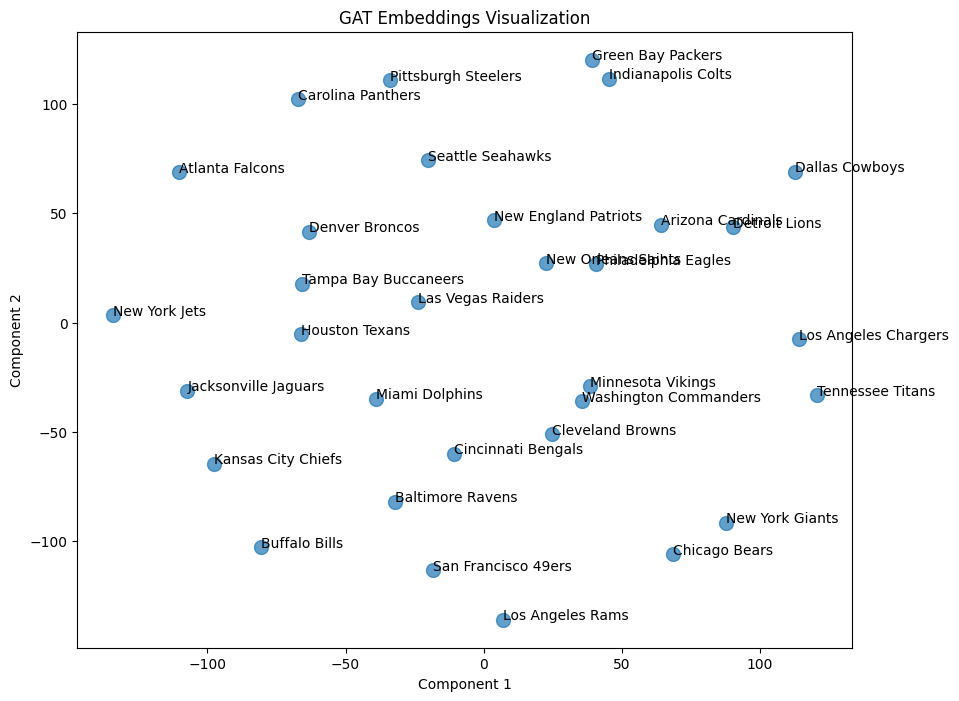

In [42]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming `embeddings` is a tensor of shape [num_nodes, embedding_dim]
embeddings_np = embeddings.cpu().numpy()  # Convert to NumPy for compatibility with sklearn

# Choose either PCA or t-SNE for dimensionality reduction
# Option 1: PCA
# pca = PCA(n_components=2)
# reduced_embeddings = pca.fit_transform(embeddings_np)

# Option 2: t-SNE (for potentially better separation but slower)
tsne = TSNE(n_components=3, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings_np)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100, alpha=0.7)
plt.title("GAT Embeddings Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Optional: Annotate points with team names or IDs
for i, team in enumerate(teams):
    plt.annotate(team, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.show()


In [10]:
print(len(teams))

37


In [43]:
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling, train_test_split_edges

In [ ]:
# Initialize the model
in_channels = node_features.size(1)  # Assuming you use random features as before
hidden_channels = 32
out_channels = 16
model = GATModel(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels).to(device)

# Temporarily remove edge attributes to allow edge splitting
data.edge_attr = None  # Remove edge_attr to use train_test_split_edges

# Perform train/test split on edges
# data = train_test_split_edges(data)

# You can still access `edge_attr` separately if needed
edge_attr = data.edge_attr  # Store edge_attr separately if you need it later


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 2. Encode nodes using GAT layers
    z = model.encode(node_features, data.train_pos_edge_index)
    
    # 3. Positive and negative samples for training
    pos_edge_index = data.train_pos_edge_index  # Positive edges from training set
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=z.size(0),
        num_neg_samples=pos_edge_index.size(1)
    )  # Random negative samples
    
    # 4. Decode edges
    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)
    
    # 5. Create labels for positive and negative samples
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # 6. Compute loss (binary cross-entropy)
    loss = F.binary_cross_entropy_with_logits(torch.cat([pos_pred, neg_pred]), torch.cat([pos_label, neg_label]))
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluation (link prediction on the test set)
model.eval()
with torch.no_grad():
    z = model.encode(node_features, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.test_pos_edge_index)
    neg_pred = model.decode(z, data.test_neg_edge_index)
    
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # Concatenate predictions and labels for evaluation
    pred = torch.cat([pos_pred, neg_pred])
    label = torch.cat([pos_label, neg_label])
    
    # Use a threshold (e.g., 0.5) on the sigmoid output to classify edges
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    accuracy = (pred_class == label).sum().item() / label.size(0)
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")